In [1]:
from fastai.vision.all import *
from moving_mnist.models.phy_original import *
from moving_mnist.models.seq2seq import TeacherForcing
from moving_mnist.models.conv_rnn import StackUnstack, StackLoss, MultiImageDice
from moving_mnist.data import *

In [2]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    print(torch.cuda.get_device_name())
    device = 0

Quadro RTX 8000


# Train PhyDNet:

We wil predict:
- `n_in`: 5 images
- `n_out`: 5 images  
- `n_obj`: up to 3 objects

In [3]:
Path.cwd()

Path('/home/tcapelle/SteadySun/moving_mnist')

In [4]:
DATA_PATH = Path.cwd()/'data'

In [5]:
ds = MovingMNIST(DATA_PATH, n_in=5, n_out=5, n_obj=[1,2], th=None)

In [6]:
train_tl = TfmdLists(range(25000), ImageTupleTransform(ds))
valid_tl = TfmdLists(range(100), ImageTupleTransform(ds))

In [7]:
# i=0
# fat_tensor = torch.stack([torch.cat(train_tl[i][0], 0) for i in range(100)])

# m,s = fat_tensor.mean(), fat_tensor.std()

In [8]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=64,#).cuda()
                             after_batch=[Normalize.from_stats(*mnist_stats)]).cuda()

In [9]:
mse_loss = StackLoss(MSELossFlat(axis=1))
metrics = []

Left: Input, Right: Target

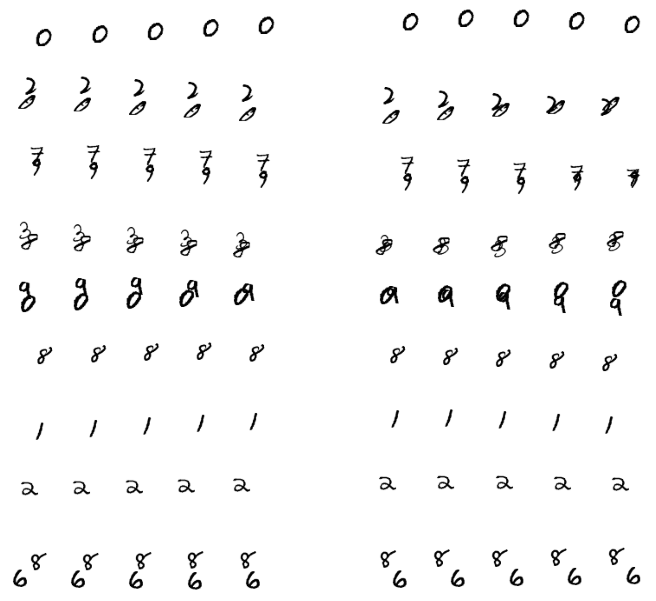

In [10]:
dls.show_batch()

In [11]:
b = dls.one_batch()

In [12]:
explode_types(b)

{tuple: [{moving_mnist.data.ImageSeq: [fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW]},
  {moving_mnist.data.ImageSeq: [fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW,
    fastai.torch_core.TensorImageBW]}]}

## PhyDNet with dual LSTM instead of PhyCell
> We replace the inner PhyCell by just ConvLSTM layers

In [13]:
# phycell =  PhyCell(input_shape=(16,16), input_dim=64, F_hidden_dims=[49], n_layers=1, kernel_size=(7,7)) 
convlstm = ConvLSTM(input_shape=(16,16), input_dim=64, hidden_dims=[128,128,64], n_layers=3, kernel_size=(3,3))   
convlstm2 = ConvLSTM(input_shape=(16,16), input_dim=64, hidden_dims=[128,128,64], n_layers=3, kernel_size=(3,3))   
encoder =  EncoderRNN(convlstm2, convlstm)

layer  0 input dim  64  hidden dim  128
layer  1 input dim  128  hidden dim  128
layer  2 input dim  128  hidden dim  64
layer  0 input dim  64  hidden dim  128
layer  1 input dim  128  hidden dim  128
layer  2 input dim  128  hidden dim  64


In [14]:
model = StackUnstack(PhyDNet(encoder, sigmoid=False, moment=True), dim=1).cuda()

A handy callback to include the loss computed inside the model to the target loss

In [15]:
#export
class PHyCallback(Callback):
    def after_pred(self):
        self.learn.pred, self.loss_phy = self.pred
    def after_loss(self):
        self.learn.loss += self.loss_phy

In [16]:
learn = Learner(dls, model, loss_func=mse_loss, metrics=metrics, 
                cbs=[TeacherForcing(10), PHyCallback()], opt_func=ranger)

SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.0012022644514217973)

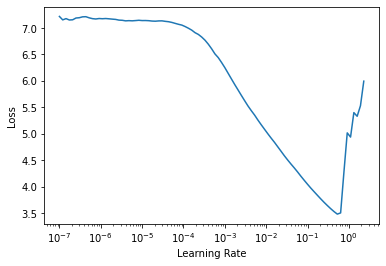

In [17]:
learn.lr_find()

In [18]:
learn.fit_flat_cos(25, 3e-3)

epoch,train_loss,valid_loss,time
0,0.751772,0.828895,02:09
1,0.726362,0.774711,02:10
2,0.711228,0.754423,02:10
3,0.710111,0.669803,02:10
4,0.676292,0.706133,02:10
5,0.666376,0.661772,02:10
6,0.653669,0.644562,02:10
7,0.648538,0.601583,02:10
8,0.652141,0.655571,02:10
9,0.645463,0.591926,02:10


In [19]:
p,t = learn.get_preds(1)

In [20]:
len(p), p[0].shape

(5, torch.Size([100, 1, 64, 64]))

In [21]:
def show_res(t, idx, argmax=False):
    if argmax:
        im_seq = ImageSeq.create([t[i][idx].argmax(0).unsqueeze(0) for i in range(5)], TensorMask)
    else:
        im_seq = ImageSeq.create([t[i][idx] for i in range(5)])
    im_seq.show(figsize=(8,4));

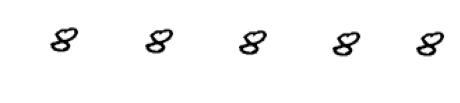

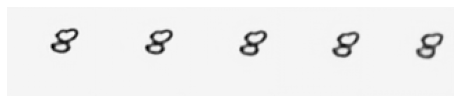

In [55]:
k = random.randint(0,99)
show_res(t,k)
show_res(p,k)

In [23]:
learn.save('phydnet')

Path('models/phydnet.pth')